# Introduction

This notebook has the basic steps for getting a model up and running on a new set of data. 
## Steps
1. Exploratory data analysis (EDA)
2. Preprocessing
3. Model selection
4. Model implementation
5. Model evaluation
6. Improvements

I hope you have fun with this notebook! 

### 0. Import libraries and get data

To help this notebook be self-contained, I have generated some data. 

In [24]:
# Let's import the libraries we need

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from sklearn.metrics import classification_report

In [3]:
# Let's generate some data to play with. 

data = pd.DataFrame()

data['col0'] = np.random.randint(20, 50, [10000])
data['col1'] = np.random.randn(10000)
data['col2'] = 0
data['col3'] = np.random.uniform(0, 5000, [10000])
data['col4'] = np.random.randint(0, 5, [10000])
data['output0'] = 20*data.col0 + 0.01*data.col3 + 10*data.col1 + 5*np.random.randn(10000)
data['output1'] = np.sign(data.output0 - 700)/2 + 0.5

data.head()

,col0,col1,col2,col3,col4,output0,output1
0,42,0.642244,0,1686.460377,1,867.626461,1.0
1,22,-1.564389,0,5.342612,1,432.948660,0.0
2,45,-0.659036,0,4927.671234,1,939.808789,1.0
3,44,-0.361915,0,1672.038537,1,899.304310,1.0
4,43,-0.617725,0,4444.049992,2,902.555552,1.0


In [4]:
# Other useful options

# pd.set_option()
# pd.read_csv("filename")

### 1. Exploratory data analysis

In [5]:
data.describe()

,col0,col1,col2,col3,col4,output0,output1
count,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,34.544700,0.028965,0.0,2508.419282,2.013400,716.309523,0.530000
std,8.636565,1.009373,0.0,1448.763644,1.414998,173.798465,0.499124
min,20.000000,-3.627151,0.0,0.283189,0.000000,373.592968,0.000000
25%,27.000000,-0.663560,0.0,1251.303539,1.000000,567.356904,0.000000
50%,35.000000,0.029552,0.0,2532.161516,2.000000,717.873961,1.000000
75%,42.000000,0.706628,0.0,3765.222938,3.000000,863.664389,1.000000
max,49.000000,3.801146,0.0,4999.138757,4.000000,1055.326138,1.000000


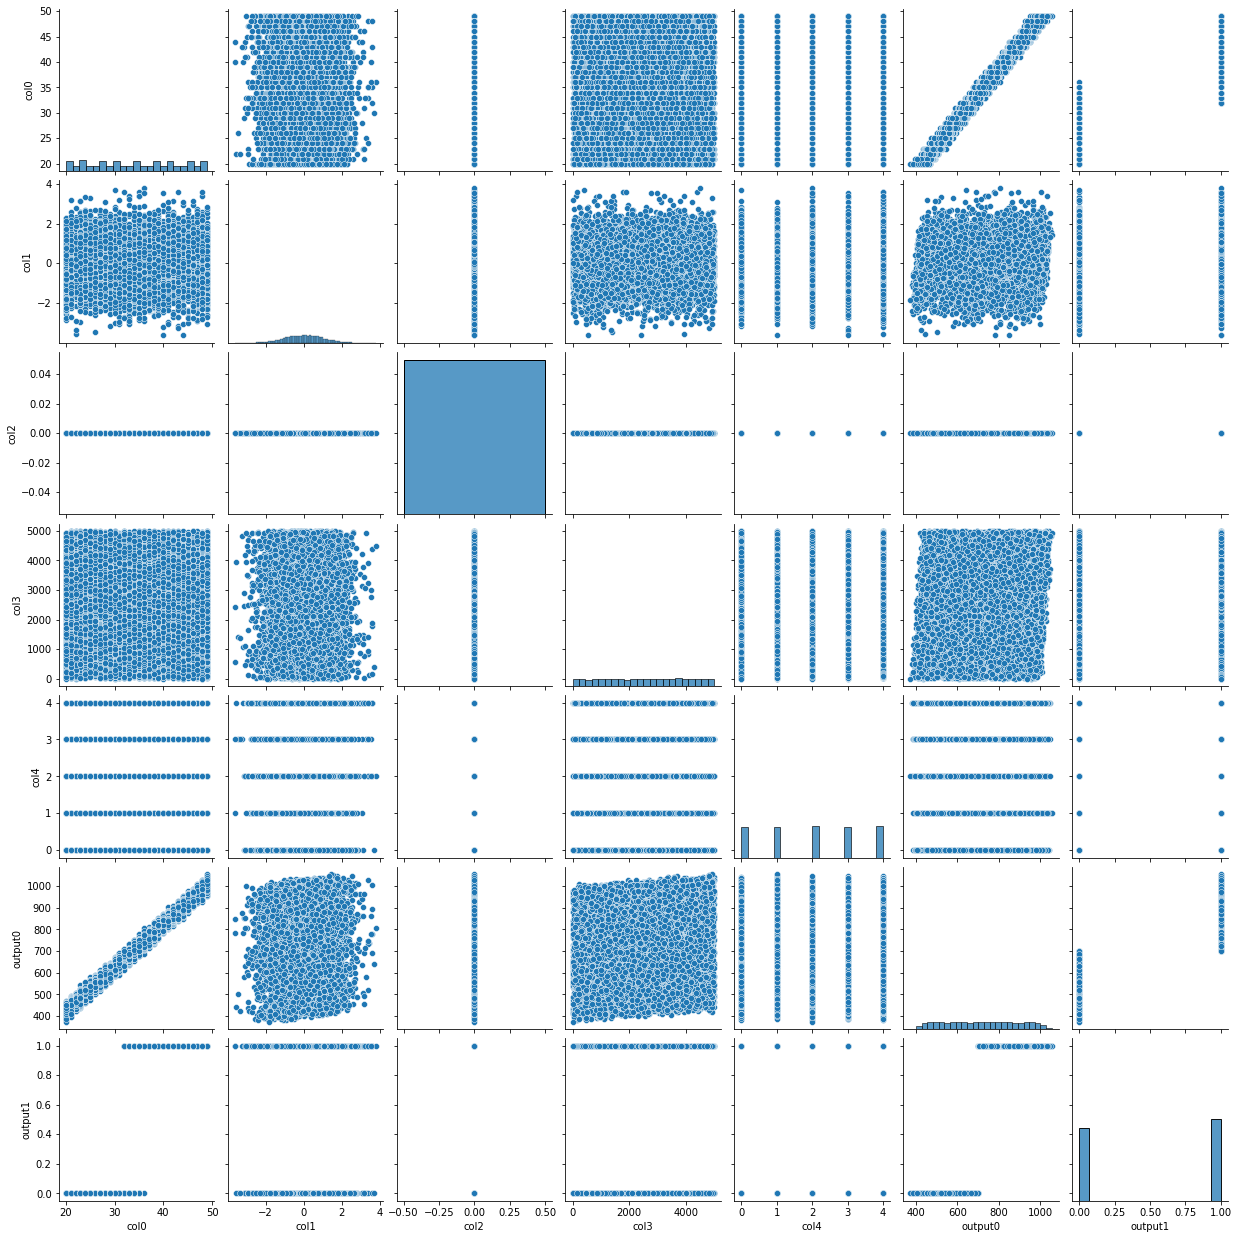

In [6]:
sns.pairplot(data)
plt.show()

In [7]:
# Contingency table for categorical variables

pd.crosstab(data.col4, data.output1, margins=True) # also an option: normalize=True

output1,0.0,1.0,All
col4,,,
0,910,1066,1976
1,912,1066,1978
2,949,1071,2020
3,992,996,1988
4,937,1101,2038
All,4700,5300,10000


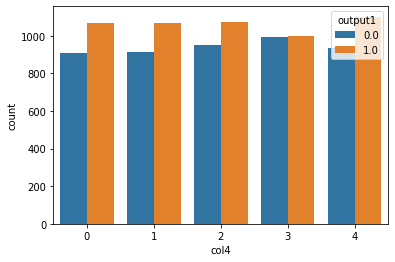

In [8]:
sns.countplot(x="col4", hue="output1", data=data)
plt.show()

In [9]:
# Other EDA options

# data.describe(include=["object", "bool"])
# print(data.shape)
# print(data.columns)
# print(data.info)
# data.[column].value_counts()
# data.sort_values(by=["col0", "col1"], ascending=[True, False])
# data.loc[rows, columns]
# data.iloc[rows, columns]
# data.drop_duplicates(axis=0)

### 2. Preprocessing

In [10]:
# drop 0 columns
data = data.drop(['col2'], axis=1)
data

,col0,col1,col3,col4,output0,output1
0,42,0.642244,1686.460377,1,867.626461,1.0
1,22,-1.564389,5.342612,1,432.948660,0.0
2,45,-0.659036,4927.671234,1,939.808789,1.0
3,44,-0.361915,1672.038537,1,899.304310,1.0
4,43,-0.617725,4444.049992,2,902.555552,1.0
...,...,...,...,...,...,...
9995,42,0.658791,2533.374722,4,873.520763,1.0
9996,46,1.071874,3568.616831,4,971.095227,1.0
9997,44,-0.698487,1486.862472,0,892.111652,1.0
9998,27,0.071871,2330.816177,0,557.394206,0.0


In [11]:
# one hot encode categorical data
# we have multiple columns of categorical data 
# data.col0 could be categorical but it might actually be similar to continuous data (e.g. age)

one_hot_columns = pd.get_dummies(data, columns = ['col4'], dtype='int')
one_hot_columns

,col0,col1,col3,output0,output1,col4_0,col4_1,col4_2,col4_3,col4_4
0,42,0.642244,1686.460377,867.626461,1.0,0,1,0,0,0
1,22,-1.564389,5.342612,432.948660,0.0,0,1,0,0,0
2,45,-0.659036,4927.671234,939.808789,1.0,0,1,0,0,0
3,44,-0.361915,1672.038537,899.304310,1.0,0,1,0,0,0
4,43,-0.617725,4444.049992,902.555552,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,42,0.658791,2533.374722,873.520763,1.0,0,0,0,0,1
9996,46,1.071874,3568.616831,971.095227,1.0,0,0,0,0,1
9997,44,-0.698487,1486.862472,892.111652,1.0,1,0,0,0,0
9998,27,0.071871,2330.816177,557.394206,0.0,1,0,0,0,0


In [12]:
one_hot_columns.drop(['col0', 'col1', 'col3'], axis=1)

,output0,output1,col4_0,col4_1,col4_2,col4_3,col4_4
0,867.626461,1.0,0,1,0,0,0
1,432.948660,0.0,0,1,0,0,0
2,939.808789,1.0,0,1,0,0,0
3,899.304310,1.0,0,1,0,0,0
4,902.555552,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...
9995,873.520763,1.0,0,0,0,0,1
9996,971.095227,1.0,0,0,0,0,1
9997,892.111652,1.0,1,0,0,0,0
9998,557.394206,0.0,1,0,0,0,0


In [13]:
# define our X and y

X = one_hot_columns.drop(['output0'], axis=1)
y = one_hot_columns.output1

In [14]:
# we need to perform the train/test split before before normalization

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
# standardization

scaler = StandardScaler()

# scaled = pd.DataFrame(scaler.fit_transform(X_train[['col0', 'col1', 'col3']]))
# X_train[['col0', 'col1', 'col3']] = scaled.dropna(axis=0)
# y_train = X_train['output1']
# X_train.drop(['output1', 'output0'], axis=1, inplace=True)

# scaled = pd.DataFrame(scaler.fit_transform(X_test[['col0', 'col1', 'col3']]))
# X_test[['col0', 'col1', 'col3']] = scaled.dropna(axis=0)
# y_test = X_test['output1']
# X_test.drop(['output1', 'output0'], axis=1, inplace=True)

X_train[['col0', 'col1', 'col3']] = scaler.fit_transform(X_train[['col0', 'col1', 'col3']])
X_test[['col0', 'col1', 'col3']] = scaler.fit_transform(X_test[['col0', 'col1', 'col3']])
X_train.drop(['output1'], axis=1, inplace=True)
X_test.drop(['output1'], axis=1, inplace=True)


In [16]:
X_train

,col0,col1,col3,col4_0,col4_1,col4_2,col4_3,col4_4
2319,-0.756265,-0.244756,-0.429299,0,0,0,0,1
5729,-0.408397,-0.387047,-1.013428,0,0,1,0,0
6046,0.403295,0.565714,1.254781,0,0,0,1,0
9295,0.983075,0.002548,-1.079820,0,0,1,0,0
184,-1.567956,0.328996,0.576071,0,0,0,1,0
...,...,...,...,...,...,...,...,...
617,1.446898,2.676266,-1.694300,0,0,1,0,0
2750,-0.872221,-0.625042,1.029104,0,0,0,0,1
9389,0.287339,0.584284,-0.166221,0,0,1,0,0
2405,0.055427,0.216108,1.003628,0,0,0,0,1


In [17]:
# Other useful preprocessing functions not used here

# change labels and data formats
# pd.set_option()
# df[column] = df[column].astype('int64')
# df[column].value_counts(normalize=True)
# df.sort_values(by=column, ascending=False).head()

# make modifications
# df.apply(lambda)

# X.isnull().sum()

# dimensionality reduction
# dealing with class imbalance

### 3. Feature selection

More on this later

### 4. Model selection

This model has a binary output, select logistic regression in this case to start. SVM would also work well but logistic regression has the advantage

### 5. Initial model implementation

In [25]:
# complete model implementation

model = LogisticRegression()
model.fit(np.array(X_train), y_train)

y_pred = model.predict(np.array(X_test))

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{cm}')

print(classification_report(y_test, y_pred))

Accuracy: 0.995
Confusion Matrix:
[[ 947    2]
 [   8 1043]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       949
         1.0       1.00      0.99      1.00      1051

    accuracy                           0.99      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      0.99      1.00      2000



### 6. Model optimization

In [26]:
# L2 (ridge) regularization

# Define Logistic Regression model
model_l2 = LogisticRegression(solver='liblinear')

# Hyperparameter grid for inverse of regularization strength (C)
param_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0]}

# Grid search with cross-validation
logreg_cv = GridSearchCV(model_l2, param_grid, cv=5)
logreg_cv.fit(X_train, y_train)

# Best model and parameters
print("Best C:", logreg_cv.best_params_['C'])
print("Best score:", logreg_cv.best_score_)

print(classification_report(y_test, y_pred))

Best C: 100.0
Best score: 0.993
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       949
         1.0       1.00      0.99      1.00      1051

    accuracy                           0.99      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      0.99      1.00      2000



In [27]:
# L1 (lasso) regularization

# Logistic Regression with L1 penalty
model_l1 = LogisticRegression(penalty='l1', solver='liblinear')  # or 'saga'

# Tune inverse regularization parameter C
param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}
logreg_l1_cv = GridSearchCV(model_l1, param_grid, cv=5)
logreg_l1_cv.fit(X_train, y_train)

print("Best C:", logreg_l1_cv.best_params_['C'])
print("Best score:", logreg_l1_cv.best_score_)

print(classification_report(y_test, y_pred))

Best C: 10.0
Best score: 0.9932500000000001
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       949
         1.0       1.00      0.99      1.00      1051

    accuracy                           0.99      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      0.99      1.00      2000



In [28]:
# ElasticNet regularization

# Logistic Regression with ElasticNet
logreg_enet = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000)

# Tune C and l1_ratio
param_grid = {
    'C': [0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

logreg_enet_cv = GridSearchCV(logreg_enet, param_grid, cv=5)
logreg_enet_cv.fit(X_train, y_train)

print("Best parameters:", logreg_enet_cv.best_params_)
print("Best score:", logreg_enet_cv.best_score_)

print(classification_report(y_test, y_pred))

Best parameters: {'C': 1.0, 'l1_ratio': 0.5}
Best score: 0.9928750000000001
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       949
         1.0       1.00      0.99      1.00      1051

    accuracy                           0.99      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       1.00      0.99      1.00      2000



In [ ]:
# sensitivity, specificity, precision, recall, f-1 score, RMSE, R**2